In [1]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

%matplotlib inline


In [16]:
data_dir = "./coordinates/"

In [10]:
torch.cuda.current_device()

0

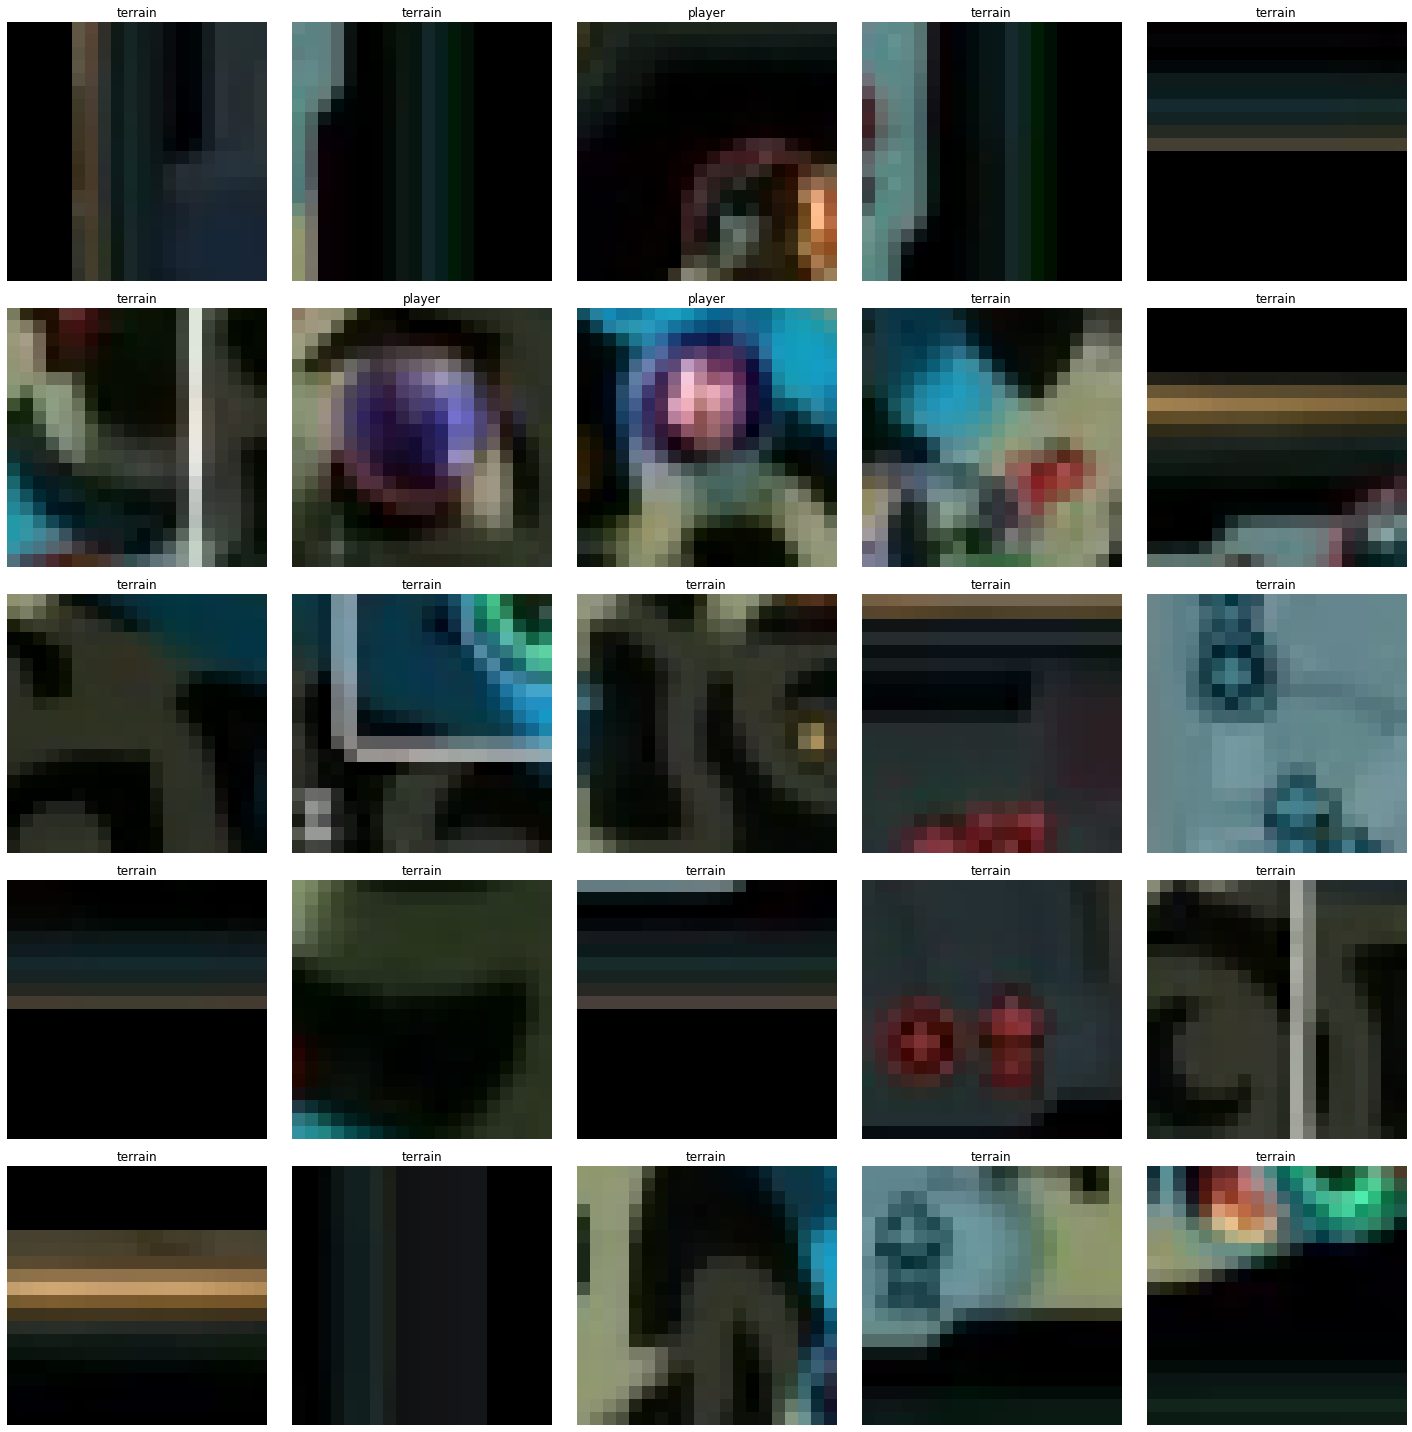

In [11]:
tfms = [[crop_pad()], [crop_pad()]]
data = ImageDataBunch.from_folder(data_dir+"split", classes=["terrain", "player"], bs=256, ds_tfms=tfms)
data.show_batch()

In [12]:
def get_score(learn):
    preds = learn.get_preds(DatasetType.Valid)[0]
    score = 0
    for i in range(len(learn.data.valid_dl.y)):
        if preds[i][0] > preds[i][1] and learn.data.valid_dl.y[i].data == 0:
            score+=1
        elif preds[i][0] < preds[i][1] and learn.data.valid_dl.y[i].data == 1:
            score+=1    

    return score

In [13]:
best_learn = None
best_score = 0
lr = 0.02

for i in range(0, 5):
    learn = create_cnn(data, models.resnet50, metrics=[accuracy])
    gc.collect()
    learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
    learn.fit_one_cycle(1, lr)
    learn.unfreeze()
    learn.fit_one_cycle(3, slice(1e-6, lr/5))

    new_score = get_score(learn)
    if new_score > best_score or not best_learn:
        best_learn = learn
        best_score = new_score
    print(f'Run {i} - Best Score: {best_score}')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/isaac/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 15.2MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.063867,0.053354,0.978849,00:24


Better model found at epoch 0 with valid_loss value: 0.05335381627082825.


epoch,train_loss,valid_loss,accuracy,time
0,0.053259,0.055148,0.978903,00:30
1,0.042330,0.050656,0.978849,00:29
2,0.016389,0.065373,0.979823,00:29


Better model found at epoch 0 with valid_loss value: 0.05514778569340706.
Better model found at epoch 1 with valid_loss value: 0.050655547529459.


Run 0 - Best Score: 18095


epoch,train_loss,valid_loss,accuracy,time
0,0.062851,0.050225,0.979985,00:22


Better model found at epoch 0 with valid_loss value: 0.05022531375288963.


epoch,train_loss,valid_loss,accuracy,time
0,0.051972,0.053160,0.979444,00:29
1,0.042313,0.055500,0.977929,00:29


Better model found at epoch 0 with valid_loss value: 0.05315980687737465.


KeyboardInterrupt: 

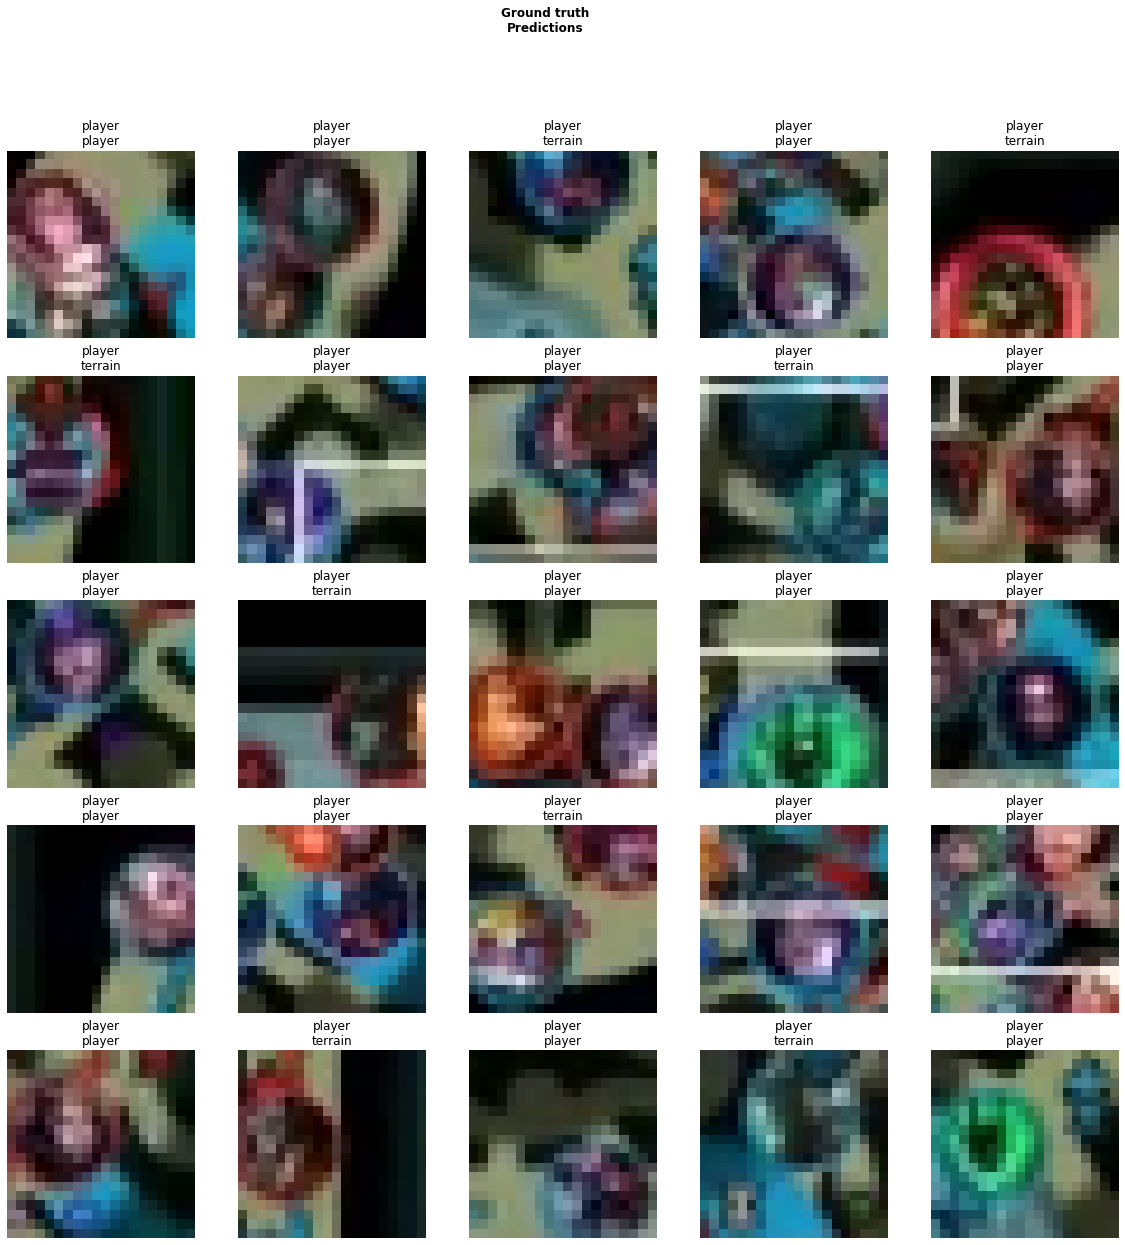

In [14]:
best_learn.show_results()

### Test on Images

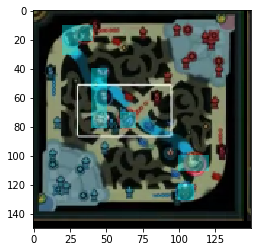

In [29]:
grid_size = 10

def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
            
def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
def draw_preds(filename, grids): 
    img = PIL.Image.open(filename)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, grids)
    out = PIL.Image.alpha_composite(img, overlay)

    imshow(np.asarray(out))

def get_grids(learn, filename):     
    # Split the image into grids and save the components to the tmp directory.
    empty_dir(data_dir+"tmp")
    im = PIL.Image.open(filename)
    imgwidth, imgheight = im.size
    for i in range(0, imgheight, grid_size):
        for j in range(0, imgwidth, grid_size):
            box = (j-5, i-5, j + grid_size + 5, i + grid_size + 5)
            a = im.crop(box)
            a.save(data_dir+f"tmp/{j*1000//grid_size+i//10}.png")

    # Predict the grid image types
    test = ImageList.from_folder(data_dir+"tmp")
    best_learn.data.add_test(test)
    preds = best_learn.get_preds(ds_type=DatasetType.Test)

    # Convert the predictions to grid coordinates
    grids = []
    for img in test.items:
        num = int(img.stem)
        x = num//1000
        y = num%1000
        grids.append((x,y))

    # Identify the grids which are players squares
    player_grids = []
    for i in range(len(preds[1])):
        if preds[0][i][1] > 0.5:
            player_grids.append(grids[i])
    
    return player_grids
# filename = "games/hka_lk_worlds_2019/full/hka_lk_worlds_2019_0000000611.png"
filename = "games/hka_lk_worlds_2019/full/hka_lk_worlds_2019_0000000508.png" # This one is hard
grids = get_grids(learn, filename)
draw_preds(filename, grids)

In [71]:
model_path = '/home/ubuntu/models/'
learn.export(model_path+"coordinator")

### Collect Full Games Maps

In [72]:
games_dir = data_dir + "games/"
empty_dir(data_dir + "full")
empty_dir(data_dir + "team")

games = os.listdir(games_dir)
for g in games:
    if g == ".DS_Store":
        os.remove(games_dir+g)
        continue
    full_dir = games_dir + g + "/full/"
    full_images = os.listdir(full_dir)
    for img in full_images:
        if ".jpg" in img or ".png" in img:
            copyfile(full_dir + img, data_dir + "full/" + img)
    team_dir = games_dir + g + "/team/"
    team_images = os.listdir(team_dir)
    for img in team_images:
        if ".jpg" in img or ".png" in img:
            copyfile(team_dir + img, data_dir + "team/" + img)

print(f"Full images: {len(os.listdir(data_dir + 'full'))}")
print(f"Team images: {len(os.listdir(data_dir + 'team'))}")

Full images: 38385
Team images: 38385


In [30]:
# fulls = os.listdir(data_dir + 'full')
# teams = os.listdir(data_dir + 'team')
# for f in fulls:
#     if f not in teams:
#         print(f)
# shutil.rmtree(data_dir + 'full/models')

### Create Full Map Coordinates

In [73]:
fnames = []
tags = []
i = 0
for f in os.listdir(data_dir+"full"):
    if not ".png" in f:
        continue
    fnames.append(f[:-4])
    grids = get_grids(learn, data_dir + f"full/{f}")
    grids = [f"{g[0]}-{g[1]}" for g in grids]
    grids.sort()
    grids = " ".join(grids)
    tags.append(grids)
    i += 1
    print(i)
df = pd.DataFrame({'image_name':fnames, 'tags':tags}, columns=['image_name', 'tags'])
df.to_csv(data_dir+"/full_coordinates.csv", index=False)

38384


In [74]:
df = pd.DataFrame({'image_name':fnames, 'tags':tags}, columns=['image_name', 'tags'])
convert_dict = {'image_name': str, 
                'tags': str
               } 
  
df = df.astype(convert_dict)
df.replace('', np.nan, inplace=True)
df.dropna(subset=['tags'], inplace=True)
df.to_csv(data_dir+"/full_coordinates.csv", index=False)